In [17]:
import importlib
from libs import models, plots, trades, params
importlib.reload(models)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(trades)

import pandas as pd
import numpy as np
import math

from pathlib import Path
import pickle
import datetime as dt
from datetime import datetime

from tqdm import tqdm
import matplotlib.pyplot as plt   
import numpy as np

import torch
import torch.nn.functional as Funct
from torch.utils.data import Dataset, DataLoader
torch.serialization.add_safe_globals([models.DayDataset])


In [2]:
device               = params.device
ticker               = params.ticker
base_path            = params.save_path
look_back            = params.look_back
label_col            = params.label_col
feature_cols         = params.feature_cols
pred_threshold       = params.pred_threshold_man
regular_start        = params.regular_start
trailing_stop_thresh = params.trailing_stop_thresh_man

# model path
val_rmse_str = "0.2619"   # same rmse in the filename
model_path = base_path / f"{ticker}_{val_rmse_str}.pth"
model_path

PosixPath('dfs training/GOOGL_0.2619.pth')

In [3]:
# Load the entire model object (architecture + weights)
model_best = torch.load(model_path, map_location=device, weights_only=False)
model_best.to(device).eval()
model_best

DualMemoryLSTM(
  (short_lstm): LSTM(5, 128, batch_first=True)
  (attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
  )
  (do_short): Dropout(p=0.3, inplace=False)
  (ln_short): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (long_lstm): LSTM(128, 256, batch_first=True)
  (do_long): Dropout(p=0.4, inplace=False)
  (ln_long): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (pred): Linear(in_features=256, out_features=1, bias=True)
)

In [4]:
dataset_test_path = base_path / f"{ticker}_test_ds.pt"
dataset_test = torch.load(dataset_test_path)

dataloader_test = DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

dataset_val_path = base_path / f"{ticker}_val_ds.pt"
dataset_val = torch.load(dataset_val_path)

dataloader_val = DataLoader(
    dataset_val,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

dataloader_test, dataloader_val

(<torch.utils.data.dataloader.DataLoader at 0x7f21dce2bb90>,
 <torch.utils.data.dataloader.DataLoader at 0x7f1e692aef00>)

In [5]:
# zero‐forecast baseline on val vs test
# √( mean( (yᵢ – 0)² ) )

val_baseline  = models.naive_rmse(dataloader_val)
test_baseline = models.naive_rmse(dataloader_test)

print(f"Val zero‐forecast baseline RMSE  = {val_baseline:.5f}")
print(f"Test zero‐forecast baseline RMSE = {test_baseline:.5f}")

Val zero‐forecast baseline RMSE  = 0.48778
Test zero‐forecast baseline RMSE = 0.37577


std val: 0.32359964
std test: 0.25987574


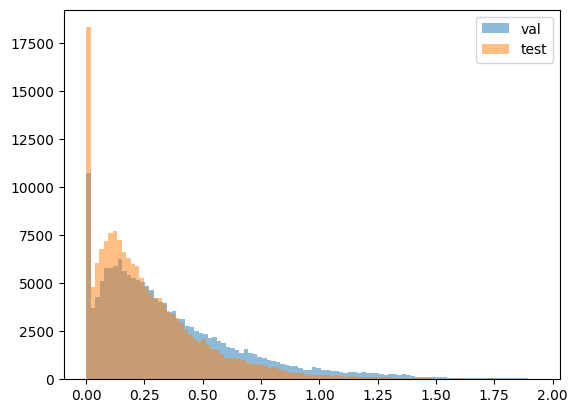

In [6]:
# to confirm the baseline proportions, calculate the STD
# σ = √( mean( (yᵢ – ȳ)² ) )

y_vals = np.concatenate([batch[1].view(-1).numpy()
                         for batch in dataloader_val])
y_tes  = np.concatenate([batch[1].view(-1).numpy()
                         for batch in dataloader_test])
print("std val:", np.std(y_vals))
print("std test:", np.std(y_tes))

plt.hist(y_vals, bins=100, alpha=0.5, label="val")
plt.hist(y_tes,  bins=100, alpha=0.5, label="test")
plt.legend(); plt.show()

In [7]:

# def rmse_over_windows(model, loader, device, split_name="Test"):
#     """
#     Compute model RMSE over all sliding windows:
#       - reset LSTM states per day/week
#       - sum squared errors, divide by total windows, sqrt
#       - show progress with tqdm, print final summary
#     """
#     model.to(device).eval()
#     model.h_short = model.h_long = None

#     prev_wd        = None
#     total_sq_error = 0.0
#     total_windows  = 0

#     with torch.no_grad():
#         for batch in tqdm(loader, desc=f"{split_name} RMSE", unit="day"):
#             # unpack: xb_day, yb_day, [raw_*...], wd
#             xb_day, yb_day, *_, wd = batch
#             wd = int(wd.item())

#             # reset states
#             model.reset_short()
#             if prev_wd is not None and wd < prev_wd:
#                 model.reset_long()
#             prev_wd = wd

#             # get inputs and targets
#             x    = xb_day[0].to(device)        # (W, look_back, F)
#             y    = yb_day.view(-1).to(device)  # (W,)
#             pred = model(x)[:, -1, 0]          # (W,)

#             # accumulate
#             total_sq_error += (pred - y).pow(2).sum().item()
#             total_windows  += y.size(0)

#     rmse = math.sqrt(total_sq_error / total_windows)
#     print(f"\n{split_name} RMSE over {total_windows} windows = {rmse:.5f}")
#     return rmse

# # Usage:
# val_rmse  = rmse_over_windows(model_best, dataloader_val,   device, split_name="Validation")
# test_rmse = rmse_over_windows(model_best, dataloader_test,  device, split_name="Test")

In [8]:

def evaluate_model(
    model: torch.nn.Module,
    loader: torch.utils.data.DataLoader,
    device: torch.device,
    split_name: str = "Test",
    compute_rmse: bool = True,
    collect_preds: bool = False
):
    """
    Run your LSTM over every day in `loader`, with the same reset logic
    you use in rmse_over_windows and collect_predictions, but controlled by flags:
      - compute_rmse: if True, accumulates MSE and returns RMSE
      - collect_preds: if True, gathers every window's prediction into a flat array

    Returns:
      (rmse, preds) where:
        • rmse is a float if compute_rmse else None
        • preds is a 1D np.ndarray if collect_preds else None

    You can call:
      rmse, _     = evaluate_model(model, loader, device, split_name, True, False)
      _, preds    = evaluate_model(model, loader, device, split_name, False, True)
      rmse, preds = evaluate_model(model, loader, device, split_name, True, True)
    """
    # Move model & reset its internal state
    model.to(device).eval()
    model.h_short = model.h_long = None

    prev_wd        = None
    total_sq_error = 0.0     # for RMSE
    total_windows  = 0       # counter for windows
    all_preds      = []      # list to store per-day preds

    # Iterate exactly as in two original functions
    with torch.no_grad():
        for batch in tqdm(loader, desc=f"{split_name}", unit="day"):
            # Unpack: xb_day, yb_day, optional raw_*, wd
            xb_day, yb_day, *_, wd = batch
            wd_val = int(wd.item())

            # reset per-day LSTM
            model.reset_short()
            # reset per-week LSTM on weekday wrap
            if prev_wd is not None and wd_val < prev_wd:
                model.reset_long()
            prev_wd = wd_val

            # pull input windows and true targets
            x    = xb_day[0].to(device)        # shape: (W, look_back, F)
            y    = yb_day.view(-1).to(device)  # shape: (W,)

            # forward pass → get last-step prediction
            out  = model(x)                    # (W, look_back, 1)
            pred = out[:, -1, 0]               # (W,)

            # accumulate RMSE stats if requested
            if compute_rmse:
                total_sq_error += (pred - y).pow(2).sum().item()
                total_windows  += y.numel()

            # collect raw preds if requested
            if collect_preds:
                all_preds.append(pred.cpu().numpy())

    # compute final RMSE
    rmse = None
    if compute_rmse:
        rmse = math.sqrt(total_sq_error / total_windows)
        print(f"\n{split_name} RMSE over {total_windows} windows = {rmse:.5f}")

    # flatten collected predictions
    preds = None
    if collect_preds:
        preds = np.concatenate(all_preds, axis=0)

    return rmse, preds


In [9]:
val_rmse, _     = evaluate_model(model_best, dataloader_val, device, split_name="Validation")
test_rmse, _     = evaluate_model(model_best, dataloader_test, device, split_name="Test")


Validation: 100%|██████████| 410/410 [00:03<00:00, 129.77day/s]



Validation RMSE over 160310 windows = 0.26191


Test: 100%|██████████| 422/422 [00:04<00:00, 85.83day/s] 


Test RMSE over 165002 windows = 0.23055


In [10]:
# def add_pred_actions(
#     preds: np.ndarray,
#     csv_dir: str = "./dfs training"
# ):
#     """
#     Attach two columns:
#       - pred_signal : the raw float prediction
#       - pred_action : discrete {+1,0,−1} by threshold
#     """
#     path_csv = f"{csv_dir}/{ticker}_test_DF.csv"

#     # read full test DataFrame (timestamps + all columns)
#     df = pd.read_csv(path_csv, index_col=0, parse_dates=True)
#     df.sort_index(inplace=True)

#     # sanity check: preds must align one‐to‐one with df rows
#     if len(df) != len(preds):
#         raise ValueError(
#             f"Row count mismatch: DF has {len(df)} rows, "
#             f"preds has {len(preds)} entries."
#         )

#     # attach continuous signal
#     df["pred_signal"] = preds

#     # ── FILTER ──
#     # keep only rows at or after the regular market open
#     df = df[df.index.time >= regular_start]

#     # now call your trading‐logic on that filtered frame
#     df = trades.generate_trade_actions(
#         df                   = df,               # filtered rows only
#         col_signal           = "pred_signal",
#         col_action           = "pred_action",
#         buy_threshold        = pred_threshold,
#         trailing_stop_thresh = trailing_stop_thresh,
#         regular_start        = regular_start
#     )

#     # save final CSV (overwriting the filtered view)
#     df.to_csv(path_csv, index=True)
#     print(f"Saved predictions & actions to {path_csv}")
#     return df


In [11]:
def add_pred_actions(
    preds: np.ndarray,
    csv_dir: str = "./dfs training"
) -> pd.DataFrame:
    """
    Attach two columns:
      - pred_signal : the raw float prediction
      - pred_action : discrete {+1,0,−1} by threshold

    We first filter out the rows for which your model actually made predictions:
      • drop the first `LOOK_BACK` minutes of each day (no sliding‐window ends there)
      • drop any minute before `regular_start` each day
    Then we align preds → rows 1:1, attach the signal, and call generate_trade_actions.
    """
    path_csv = f"{csv_dir}/{ticker}_test_DF.csv"

    # 1) Load the full-minute DataFrame and sort by time
    df_full = pd.read_csv(path_csv, index_col=0, parse_dates=True)
    df_full.sort_index(inplace=True)

    # 2) Build a filtered DataFrame containing only the rows your model saw
    filtered_days = []
    for date, day_df in df_full.groupby(df_full.index.normalize(), sort=False):
        day_df = day_df.sort_index()

        # a) drop the first LOOK_BACK rows (no window ends there)
        day_df = day_df.iloc[look_back:]

        # b) keep only minutes at or after regular_start
        day_df = day_df.loc[day_df.index.time >= regular_start]

        filtered_days.append(day_df)

    df = pd.concat(filtered_days, axis=0)

    # 3) Sanity check: now length must match preds
    if len(df) != len(preds):
        raise ValueError(
            f"Row count mismatch: filtered DF has {len(df)} rows, "
            f"but preds has {len(preds)} entries."
        )

    # 4) Attach the continuous model output
    df["pred_signal"] = preds

    # 5) Generate discrete trade actions on that filtered DF
    df = trades.generate_trade_actions(
        df                   = df,                # filtered only
        col_signal           = "pred_signal",
        col_action           = "pred_action",
        buy_threshold        = pred_threshold,
        trailing_stop_thresh = trailing_stop_thresh,
        regular_start        = regular_start
    )

    # 6) Persist results (overwrites the filtered CSV)
    df.to_csv(path_csv, index=True)
    print(f"Saved filtered predictions & actions to {path_csv}")

    return df


In [12]:
_, preds = evaluate_model(model_best, dataloader_test, device,
                          split_name="Test",
                          compute_rmse=False, collect_preds=True)

df_with_preds = add_pred_actions(preds)
df_with_preds

Test: 100%|██████████| 422/422 [00:02<00:00, 159.79day/s]


Saved filtered predictions & actions to ./dfs training/GOOGL_test_DF.csv


,open,high,low,close,volume,bid,ask,trade_action,StrategyEarning,EarningDiff,signal_smooth,pred_signal,pred_action
2023-10-12 14:30:00,141.050,141.2200,140.4432,140.4434,532078.0,140.4013,140.4855,1,-0.084,0.000,0.686669,0.106947,0
2023-10-12 14:31:00,140.435,140.7200,140.2900,140.3350,115423.0,140.2929,140.3771,0,-0.193,0.000,0.700390,0.165582,0
2023-10-12 14:32:00,140.310,140.6100,140.2300,140.4200,111591.0,140.3779,140.4621,0,-0.108,0.000,0.706180,0.168880,0
2023-10-12 14:33:00,140.430,140.4700,140.0800,140.0900,96714.0,140.0480,140.1320,0,-0.438,0.000,0.707526,0.156575,0
2023-10-12 14:34:00,140.100,140.4400,140.0600,140.3000,102922.0,140.2579,140.3421,0,-0.228,0.000,0.703992,0.150678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,173.375,173.6771,173.2150,173.5650,621199.0,173.5129,173.6171,0,-0.931,1.779,0.000000,0.218538,0
2025-06-18 20:57:00,173.565,173.5900,173.2400,173.3800,624198.0,173.3280,173.4320,0,-0.931,1.964,0.000000,0.199252,0
2025-06-18 20:58:00,173.390,173.4100,173.2000,173.3100,454542.0,173.2580,173.3620,0,-0.931,2.034,0.000000,0.197956,0
2025-06-18 20:59:00,173.315,173.4000,173.2300,173.2800,1094746.0,173.2280,173.3320,0,-0.931,2.064,0.000000,0.197040,0


In [13]:

# Run the simulator on your DataFrame of predictions/actions
sim_results = trades.simulate_trading(
    results_by_day_sign = df_with_preds,         # full DF with pred_action
    col_action          = "pred_action",         # name of the discrete action column
    regular_start       = params.regular_start,  # e.g. time(9,30)
    regular_end         = params.regular_end,    # e.g. time(16,0)
    ticker              = params.ticker
)

# sim_results is a dict: { date → (df_sim, trades_list, perf_stats) }


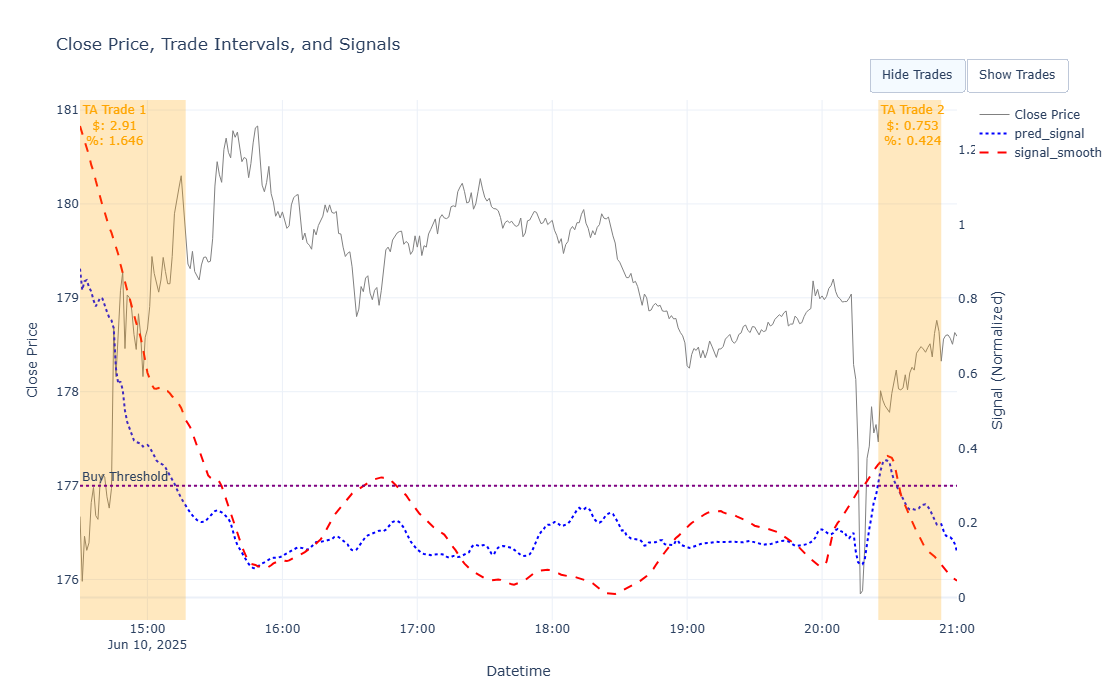

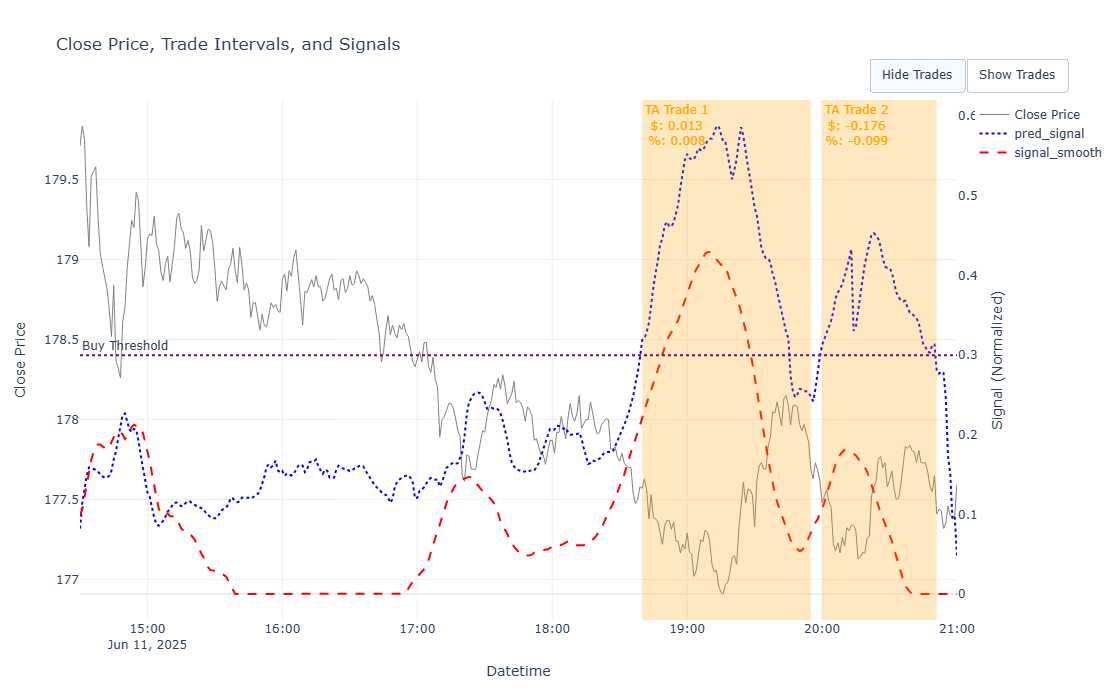

  → no simulation data for 2025-06-14, skipping.


{'Final Net Value ($)': -0.163,
 'Buy & Hold Gain ($)': -2.417,
 'Strategy Profit Difference ($)': 2.254,
 'Final Net Return (%)': -0.091,
 'Buy & Hold Return (%)': -1.345,
 'Strategy Improvement (%)': 1.254,
 'Trade Gains ($)': [0.013, -0.176],
 'Trade Gains (%)': [0.008, -0.099]}

In [20]:
# Choose which days to plot (as pandas Timestamps or ISO strings)
#    For example, let the user pick:
days_to_plot = [
    pd.to_datetime("2025-06-10"),
    pd.to_datetime("2025-06-11"),
    pd.to_datetime("2025-06-14"),
]

# Loop and plot
for day in days_to_plot:
    if day not in sim_results:
        print(f"  → no simulation data for {day.date()}, skipping.")
        continue

    df_sim, trades_list, perf_stats = sim_results[day]

    # call plot_trades from your trading library
    plots.plot_trades(
        df                = df_sim,
        col_signal1       = "pred_signal",
        col_signal2       = "signal_smooth",
        col_action        = "pred_action",          # the same discrete signal column
        trades            = trades_list,            # original trade tuple list
        buy_threshold     = params.pred_threshold_man,  # for the horizontal line
        performance_stats = perf_stats
    )

perf_stats